In [1]:
# --- Import libraries --- #
import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from scipy.special import expit as logistic
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import seaborn as sns

import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter(action="ignore")
%config InlineBackend.figure_format = 'retina'

print("Packages uploaded successfully!")

Packages uploaded successfully!


In [2]:
# --- Read data --- #
data = pd.read_csv('./machine_readable.csv')

# --- Standardise continuous values --- #
data_prep = data[['LogD', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF_EC50min', 'NNF_EC50max', 'Viability_LDH_EC50', 'Viability_AB_EC50']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['LogD', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF_EC50min', 'NNF_EC50max', 'Viability_LDH_EC50', 'Viability_AB_EC50']

# Add other discrete values and details
discrete = data [['Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF_Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

# --- Define predictors and outcomes --- #

# BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['LogD', 'Cbrain/Cblood', 'BBB', 
                            'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF_Reduction']]).values

# SYN
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
Y_syn = pd.DataFrame(data[['Activity_Syn']]).values #Y because no missing values

# NNF
x_nnf = pd.DataFrame(data[['NNF_EC50min', 'NNF_EC50max', 'Viability_LDH_EC50', 'Viability_AB_EC50']]).values
Y_nnf = pd.DataFrame(data[['Activity_NNF']]).values #Y because no missing values

# x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
Y_dnt = pd.DataFrame(data[['DNT']]).values #Y because no missing values

In [3]:
# --- Masking missing data --- #
# BDNF
x_bdnf_missing = np.isnan(x_bdnf)
X_bdnf_train = np.ma.masked_array(x_bdnf, mask=x_bdnf_missing)
y_bdnf_missing = np.isnan(y_bdnf)
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

# SYN
x_syn_missing = np.isnan(x_syn)
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)

# NNF
x_nnf_missing = np.isnan(x_nnf)
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)

In [4]:
# FIRST MODEL
# --- Define and fit the model --- #
with pm.Model() as model1:
    # Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.001) 
    sd_beta = pm.HalfNormal('sd_beta', sd=1)
    # Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(4,1))
    
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sd=0.001, shape=(1,6))
    Xsigma_bdnf = pm.HalfNormal('Xsigma_bdnf', sd=1, shape=(1,6))
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', 
                                         mu=Xmu_bdnf, sigma=Xsigma_bdnf, observed=X_bdnf_train)

    # Likelihood for BDNF
    # SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_modelled, beta_bdnf))
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)
    
    # Imputation of X missing values for SYN
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=0.001, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=1, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled',
                                 mu=Xmu_syn, sigma=Xsigma_syn, observed=X_syn_train)

    # Likelihood for SYN
    # BDNF->SYN
    lp_syn = pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_modelled, beta_syn))
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p=lp_syn, observed=Y_syn)
    
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=0.001, shape=(1,4))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=1, shape=(1,4)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled',
                                 mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    # BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf)
    
    # Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt)

# Checking the proposed structure of model
model1.check_test_point()

mu_beta                      5.99
sd_beta_log__               -0.77
beta_bdnf                   -4.16
beta_syn                    -1.39
beta_nnf                    -2.77
Xmu_bdnf                    35.93
Xsigma_bdnf_log__           -4.62
X_bdnf_modelled_missing      0.00
y_obs_bdnf_missing           0.00
Xmu_syn                     11.98
Xsigma_syn_log__            -1.54
X_syn_modelled_missing       0.00
Xmu_nnf                     23.96
Xsigma_nnf_log__            -3.08
X_nnf_modelled_missing       0.00
X_bdnf_modelled           -552.12
y_obs_bdnf                 -61.00
X_syn_modelled            -172.26
y_obs_syn                  -61.00
X_nnf_modelled            -394.00
y_obs_nnf                  -61.00
y_obs_dnt                  -61.00
Name: Log-probability of test_point, dtype: float64

In [5]:
# --- Run inferences and compute posterior distributions --- #
with model1:
    trace_model1 = pm.sample(cores=4, nuts ={'target_accept':0.90})
    #Predictions
    posterior_model1 = pm.sample_posterior_predictive(trace_model1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [6]:
# --- Convert and store in Arviz format --- #
idata_model1 = az.from_pymc3(trace=trace_model1, 
                             posterior_predictive=posterior_model1,
                             model=model1)
idata_model1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [7]:
# SECOND MODEL
# --- Define and fit the model --- #
with pm.Model() as model2:
    # Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=2)
    # Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(4,1))
    
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sd=0.01, shape=(1,6))
    Xsigma_bdnf = pm.HalfNormal('Xsigma_bdnf', sd=2, shape=(1,6))
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', 
                                         mu=Xmu_bdnf, sigma=Xsigma_bdnf, observed=X_bdnf_train)

    # Likelihood for BDNF
    # SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_modelled, beta_bdnf))
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)
    
    # Imputation of X missing values for SYN
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=0.01, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=2, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled',
                                 mu=Xmu_syn, sigma=Xsigma_syn, observed=X_syn_train)

    # Likelihood for SYN
    # BDNF->SYN
    lp_syn = pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_modelled, beta_syn))
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p=lp_syn, observed=Y_syn)
    
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=0.01, shape=(1,4))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=2, shape=(1,4)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled',
                                 mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    # BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf)
    
    # Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt)

# Checking the proposed structure of model
model2.check_test_point()

mu_beta                      3.69
sd_beta_log__               -0.77
beta_bdnf                   -8.32
beta_syn                    -2.77
beta_nnf                    -5.55
Xmu_bdnf                    22.12
Xsigma_bdnf_log__           -4.62
X_bdnf_modelled_missing      0.00
y_obs_bdnf_missing           0.00
Xmu_syn                      7.37
Xsigma_syn_log__            -1.54
X_syn_modelled_missing       0.00
Xmu_nnf                     14.74
Xsigma_nnf_log__            -3.08
X_nnf_modelled_missing       0.00
X_bdnf_modelled           -778.50
y_obs_bdnf                 -61.00
X_syn_modelled            -256.55
y_obs_syn                  -61.00
X_nnf_modelled            -525.48
y_obs_nnf                  -61.00
y_obs_dnt                  -61.00
Name: Log-probability of test_point, dtype: float64

In [8]:
# --- Run inferences and compute posterior distributions --- #
with model2:
    trace_model2 = pm.sample(cores=4, nuts ={'target_accept':0.90})
    #Predictions
    posterior_model2 = pm.sample_posterior_predictive(trace_model2)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [9]:
# --- Convert and store in Arviz format --- #
idata_model2 = az.from_pymc3(trace=trace_model2, 
                             posterior_predictive=posterior_model2,
                             model=model2)
idata_model2

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [10]:
# THIRD MODEL
# --- Define and fit the model --- #
with pm.Model() as model3:
    # Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    # Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(4,1))
    
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sd=1, shape=(1,6))
    Xsigma_bdnf = pm.HalfNormal('Xsigma_bdnf', sd=2, shape=(1,6))
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', 
                                         mu=Xmu_bdnf, sigma=Xsigma_bdnf, observed=X_bdnf_train)

    # Likelihood for BDNF
    # SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_modelled, beta_bdnf))
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)
    
    # Imputation of X missing values for SYN
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=1, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=2, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled',
                                 mu=Xmu_syn, sigma=Xsigma_syn, observed=X_syn_train)

    # Likelihood for SYN
    # BDNF->SYN
    lp_syn = pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_modelled, beta_syn))
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p=lp_syn, observed=Y_syn)
    
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=1, shape=(1,4))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=2, shape=(1,4)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled',
                                 mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    # BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf)
    
    # Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt)

# Checking the proposed structure of model
model3.check_test_point()

mu_beta                      3.69
sd_beta_log__               -0.77
beta_bdnf                  -13.82
beta_syn                    -4.61
beta_nnf                    -9.21
Xmu_bdnf                    -5.51
Xsigma_bdnf_log__           -4.62
X_bdnf_modelled_missing      0.00
y_obs_bdnf_missing           0.00
Xmu_syn                     -1.84
Xsigma_syn_log__            -1.54
X_syn_modelled_missing       0.00
Xmu_nnf                     -3.68
Xsigma_nnf_log__            -3.08
X_nnf_modelled_missing       0.00
X_bdnf_modelled           -778.50
y_obs_bdnf                 -61.00
X_syn_modelled            -256.55
y_obs_syn                  -61.00
X_nnf_modelled            -525.48
y_obs_nnf                  -61.00
y_obs_dnt                  -61.00
Name: Log-probability of test_point, dtype: float64

In [11]:
# --- Run inferences and compute posterior distributions --- #
with model3:
    trace_model3 = pm.sample(cores=4, nuts ={'target_accept':0.90})
    #Predictions
    posterior_model3 = pm.sample_posterior_predictive(trace_model3)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
# --- Convert and store in Arviz format --- #
idata_model3 = az.from_pymc3(trace=trace_model3, 
                             posterior_predictive=posterior_model3,
                             model=model3)
idata_model3

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

### Comparison of posterior densities of betas parameters given by two different priors

In [56]:
# First scenario
beta_bdnf_model1 = np.mean(np.squeeze(trace_model1["beta_bdnf"]), axis=0)
print(len(beta_bdnf_model1), beta_bdnf_model1)

6 [ 0.07367043  0.20195568  0.41010048  0.01441762 -0.03545639  0.41094298]


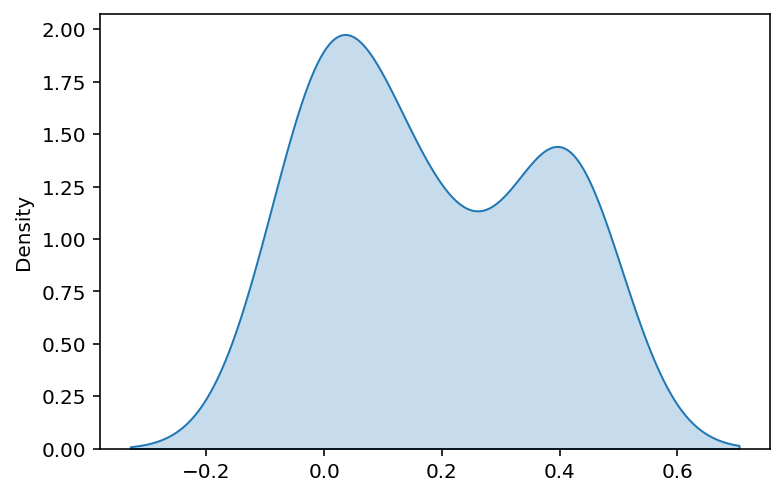

In [57]:
sns.kdeplot(beta_bdnf_model1, bw = 0.5 , fill = True);

In [58]:
# Second scenario
beta_bdnf_model1 = np.mean(np.squeeze(trace_model1["beta_bdnf"]), axis=1)
print(len(beta_bdnf_model1), beta_bdnf_model1)

4000 [0.2074722  0.251297   0.23388864 ... 0.23523831 0.10155801 0.09325717]


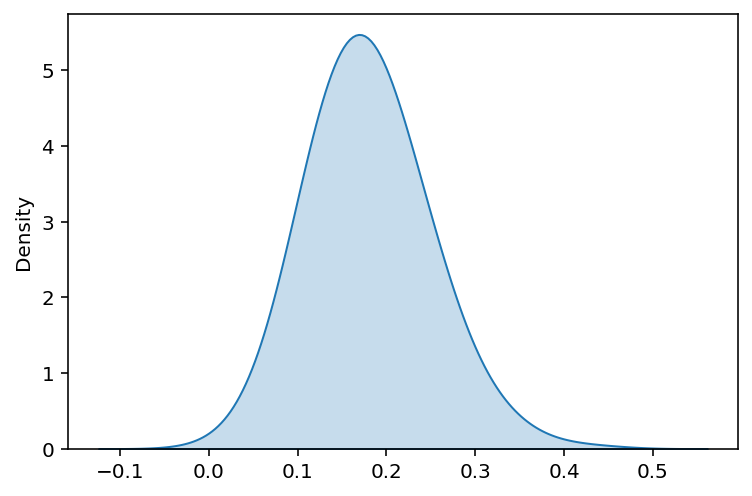

In [59]:
sns.kdeplot(beta_bdnf_model1, bw = 0.5 , fill = True);

### Going for the second scenario

In [13]:
beta_bdnf_model1 = np.mean(np.squeeze(trace_model1["beta_bdnf"]), axis=1)
beta_syn_model1 = np.mean(np.squeeze(trace_model1["beta_syn"]), axis=1)
beta_nnf_model1 = np.mean(np.squeeze(trace_model1["beta_nnf"]), axis=1)

beta_bdnf_model2 = np.mean(np.squeeze(trace_model2["beta_bdnf"]), axis=1)
beta_syn_model2 = np.mean(np.squeeze(trace_model2["beta_syn"]), axis=1)
beta_nnf_model2 = np.mean(np.squeeze(trace_model2["beta_nnf"]), axis=1)

beta_bdnf_model3 = np.mean(np.squeeze(trace_model3["beta_bdnf"]), axis=1)
beta_syn_model3 = np.mean(np.squeeze(trace_model3["beta_syn"]), axis=1)
beta_nnf_model3 = np.mean(np.squeeze(trace_model3["beta_nnf"]), axis=1)

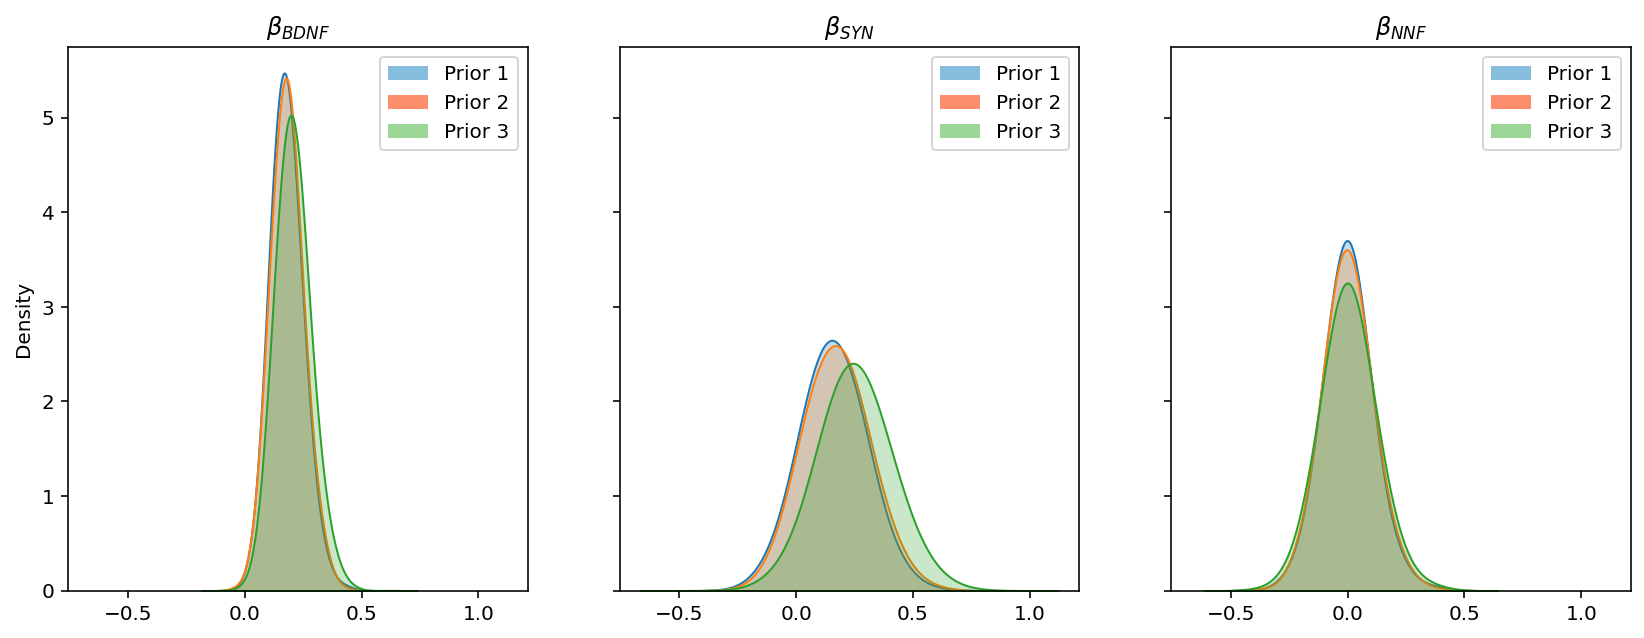

In [14]:
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(14, 5))

handles = [mpatches.Patch(facecolor=plt.cm.Blues(110), label="Prior 1"),
           mpatches.Patch(facecolor=plt.cm.Reds(100), label="Prior 2"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="Prior 3")]

sns.kdeplot(beta_bdnf_model1, bw = 0.5 , fill = True, ax = ax[0])
sns.kdeplot(beta_bdnf_model2, bw = 0.5 , fill = True, ax = ax[0])
sns.kdeplot(beta_bdnf_model3, bw = 0.5 , fill = True, ax = ax[0])
ax[0].set_title(r'$β_{BDNF}$', fontsize=12)
ax[0].legend(handles=handles)

sns.kdeplot(beta_syn_model1, bw = 0.5 , fill = True, ax = ax[1])
sns.kdeplot(beta_syn_model2, bw = 0.5 , fill = True, ax = ax[1])
sns.kdeplot(beta_syn_model3, bw = 0.5 , fill = True, ax = ax[1])
ax[1].set_title(r'$β_{SYN}$', fontsize=12)
ax[1].legend(handles=handles)

sns.kdeplot(beta_nnf_model1, bw = 0.5 , fill = True, ax = ax[2])
sns.kdeplot(beta_nnf_model2, bw = 0.5 , fill = True, ax = ax[2])
sns.kdeplot(beta_nnf_model3, bw = 0.5 , fill = True, ax = ax[2])
ax[2].set_title(r'$β_{NNF}$', fontsize=12)
ax[2].legend(handles=handles);

### Comparison posteriors predictions for each Y_obs, which represents the key events

### --- The Wrong way in my opinion. Below is the correct way

In [15]:
df_bdnf_model1 = np.squeeze(posterior_model1['y_obs_bdnf']).mean(axis=1)
df_syn_model1 = np.squeeze(posterior_model1['y_obs_syn']).mean(axis=1)
df_nnf_model1 = np.squeeze(posterior_model1['y_obs_nnf']).mean(axis=1)
df_dnt_model1 = np.squeeze(posterior_model1['y_obs_dnt']).mean(axis=1)

df_bdnf_model2 = np.squeeze(posterior_model2['y_obs_bdnf']).mean(axis=1)
df_syn_model2 = np.squeeze(posterior_model2['y_obs_syn']).mean(axis=1)
df_nnf_model2 = np.squeeze(posterior_model2['y_obs_nnf']).mean(axis=1)
df_dnt_model2 = np.squeeze(posterior_model2['y_obs_dnt']).mean(axis=1)

df_bdnf_model3 = np.squeeze(posterior_model3['y_obs_bdnf']).mean(axis=1)
df_syn_model3 = np.squeeze(posterior_model3['y_obs_syn']).mean(axis=1)
df_nnf_model3 = np.squeeze(posterior_model3['y_obs_nnf']).mean(axis=1)
df_dnt_model3 = np.squeeze(posterior_model3['y_obs_dnt']).mean(axis=1)

In [16]:
d_model1 = {'BDNF': df_bdnf_model1, 
      'SYN': df_syn_model1,
      'NNF': df_nnf_model1,
      'DNT': df_dnt_model1}
df_model1 = pd.DataFrame(d_model1)

d_model2 = {'BDNF': df_bdnf_model2, 
      'SYN': df_syn_model2,
      'NNF': df_nnf_model2,
      'DNT': df_dnt_model2}
df_model2 = pd.DataFrame(d_model2)

d_model3 = {'BDNF': df_bdnf_model3, 
      'SYN': df_syn_model3,
      'NNF': df_nnf_model3,
      'DNT': df_dnt_model3}
df_model3 = pd.DataFrame(d_model3)

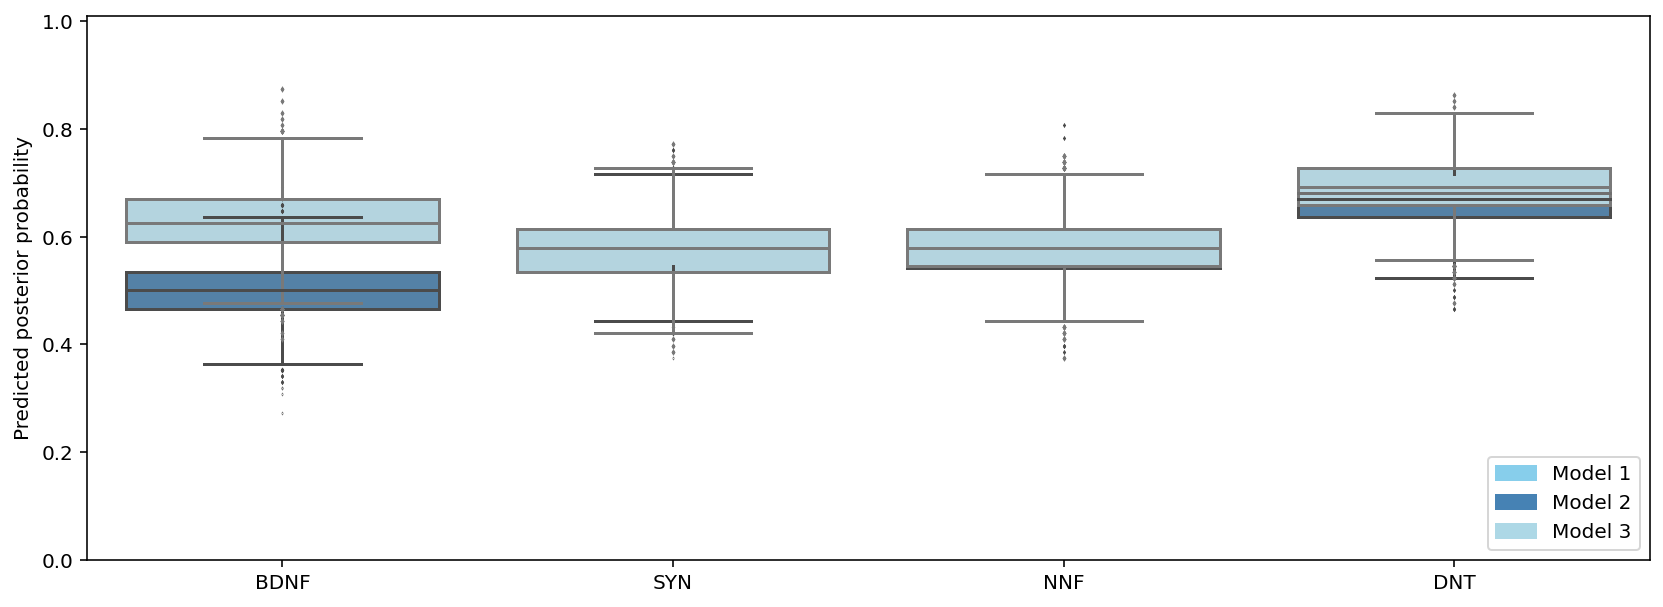

In [17]:
fig, ax = plt.subplots(figsize=(14, 5))

sns.boxplot(data = df_model1, ax = ax, fliersize=0.1, color='skyblue')
sns.boxplot(data = df_model2, ax = ax, fliersize=0.5, color='steelblue')
sns.boxplot(data = df_model3, ax = ax, fliersize=1, color='lightblue')

ax.set_ylim([0, 1.01])
ax.set_ylabel("Predicted posterior probability");

handles = [mpatches.Patch(color='skyblue', label="Model 1"),
           mpatches.Patch(color='steelblue', label="Model 2"),
           mpatches.Patch(color='lightblue', label="Model 3")]
ax.legend(handles=handles, loc=4);

## The correct way of saving the posterior probabilities data

In [18]:
obs_bdnf = np.squeeze(idata_model1.posterior_predictive['y_obs_bdnf'])
obs_pred_bdnf = np.reshape(obs_bdnf.values, (4000, 88))
avg_obs_pred_bdnf = obs_pred_bdnf.mean(axis=0)

obs_syn = np.squeeze(idata_model1.posterior_predictive['y_obs_syn'])
obs_pred_syn = np.reshape(obs_syn.values, (4000, 88))
avg_obs_pred_syn = obs_pred_syn.mean(axis=0)

obs_nnf = np.squeeze(idata_model1.posterior_predictive['y_obs_nnf'])
obs_pred_nnf = np.reshape(obs_nnf.values, (4000, 88))
avg_obs_pred_nnf = obs_pred_nnf.mean(axis=0)

obs_dnt = np.squeeze(idata_model1.posterior_predictive['y_obs_dnt'])
obs_pred_dnt = np.reshape(obs_dnt.values, (4000, 88))
avg_obs_pred_dnt = obs_pred_dnt.mean(axis=0)

avg_obs_dict_model1 = {'BDNF': avg_obs_pred_bdnf,
                'SYN': avg_obs_pred_syn,
                'NNF': avg_obs_pred_nnf,
                'DNT':avg_obs_pred_dnt}
avg_obs_pred_model1 = pd.DataFrame(avg_obs_dict_model1)



obs_bdnf_m2 = np.squeeze(idata_model2.posterior_predictive['y_obs_bdnf'])
obs_pred_bdnf_m2 = np.reshape(obs_bdnf_m2.values, (4000, 88))
avg_obs_pred_bdnf_m2 = obs_pred_bdnf_m2.mean(axis=0)

obs_syn_m2 = np.squeeze(idata_model2.posterior_predictive['y_obs_syn'])
obs_pred_syn_m2 = np.reshape(obs_syn_m2.values, (4000, 88))
avg_obs_pred_syn_m2 = obs_pred_syn_m2.mean(axis=0)

obs_nnf_m2 = np.squeeze(idata_model2.posterior_predictive['y_obs_nnf'])
obs_pred_nnf_m2 = np.reshape(obs_nnf_m2.values, (4000, 88))
avg_obs_pred_nnf_m2 = obs_pred_nnf_m2.mean(axis=0)

obs_dnt_m2 = np.squeeze(idata_model2.posterior_predictive['y_obs_dnt'])
obs_pred_dnt_m2 = np.reshape(obs_dnt_m2.values, (4000, 88))
avg_obs_pred_dnt_m2 = obs_pred_dnt_m2.mean(axis=0)

avg_obs_dict_model2 = {'BDNF': avg_obs_pred_bdnf_m2,
                'SYN': avg_obs_pred_syn_m2,
                'NNF': avg_obs_pred_nnf_m2,
                'DNT':avg_obs_pred_dnt_m2}
avg_obs_pred_model2 = pd.DataFrame(avg_obs_dict_model2)



obs_bdnf_m3 = np.squeeze(idata_model3.posterior_predictive['y_obs_bdnf'])
obs_pred_bdnf_m3 = np.reshape(obs_bdnf.values, (4000, 88))
avg_obs_pred_bdnf_m3 = obs_pred_bdnf_m3.mean(axis=0)

obs_syn_m3 = np.squeeze(idata_model3.posterior_predictive['y_obs_syn'])
obs_pred_syn_m3 = np.reshape(obs_syn_m3.values, (4000, 88))
avg_obs_pred_syn_m3 = obs_pred_syn_m3.mean(axis=0)

obs_nnf_m3 = np.squeeze(idata_model3.posterior_predictive['y_obs_nnf'])
obs_pred_nnf_m3 = np.reshape(obs_nnf_m3.values, (4000, 88))
avg_obs_pred_nnf_m3 = obs_pred_nnf_m3.mean(axis=0)

obs_dnt_m3 = np.squeeze(idata_model3.posterior_predictive['y_obs_dnt'])
obs_pred_dnt_m3 = np.reshape(obs_dnt_m3.values, (4000, 88))
avg_obs_pred_dnt_m3 = obs_pred_dnt_m3.mean(axis=0)

avg_obs_dict_model3 = {'BDNF': avg_obs_pred_bdnf_m3,
                'SYN': avg_obs_pred_syn_m3,
                'NNF': avg_obs_pred_nnf_m3,
                'DNT':avg_obs_pred_dnt_m3}
avg_obs_pred_model3 = pd.DataFrame(avg_obs_dict_model3)


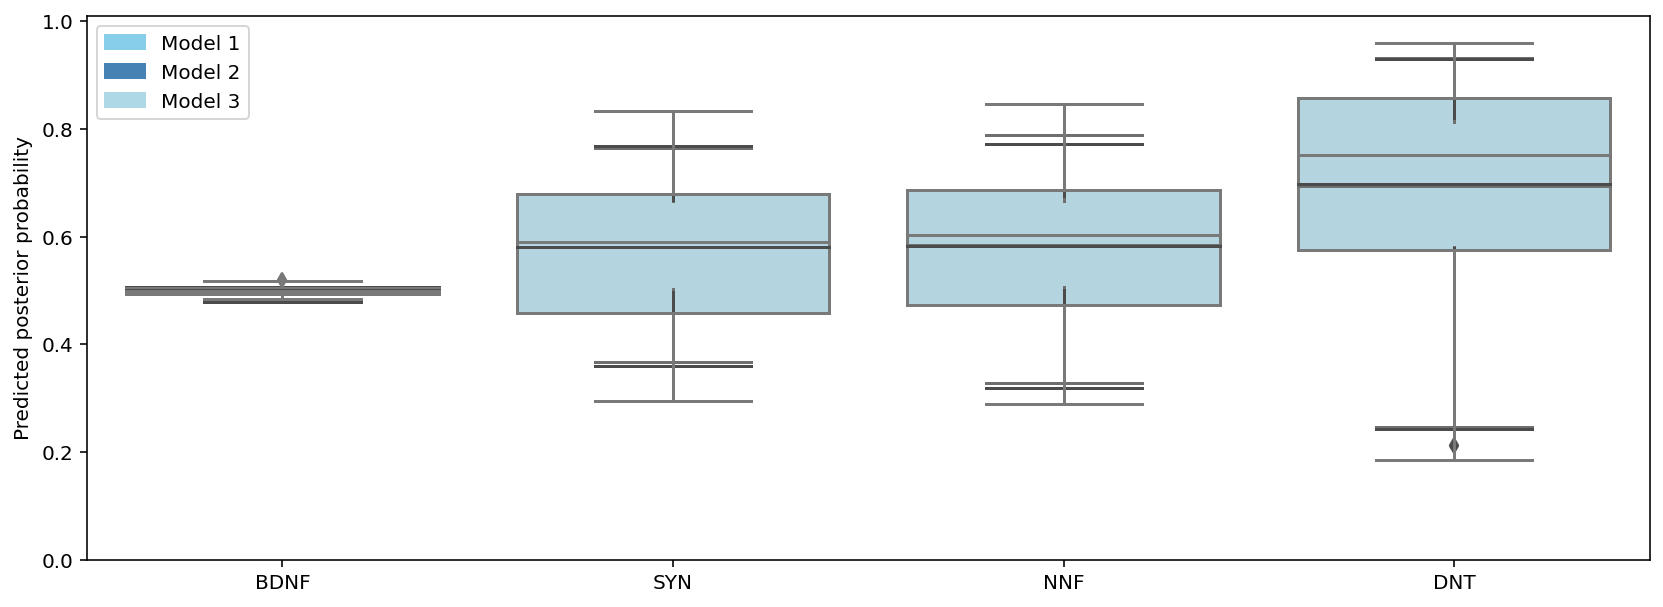

In [47]:
fig, ax = plt.subplots(figsize=(14, 5))

sns.boxplot(data = avg_obs_pred_model1, ax = ax, color='skyblue')
sns.boxplot(data = avg_obs_pred_model2, ax = ax, color='steelblue')
sns.boxplot(data = avg_obs_pred_model3, ax = ax, color='lightblue')

ax.set_ylim([0, 1.01])
ax.set_ylabel("Predicted posterior probability");

handles = [mpatches.Patch(color='skyblue', label="Model 1"),
           mpatches.Patch(color='steelblue', label="Model 2"),
           mpatches.Patch(color='lightblue', label="Model 3")]
ax.legend(handles=handles, loc=0);

### Predictions

In [62]:
# --- Convert and store in Arviz format --- #
idata_hierar = az.from_pymc3(trace=trace_model1, 
                             posterior_predictive=posterior_model1,
                             model=model1)
idata_hierar

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

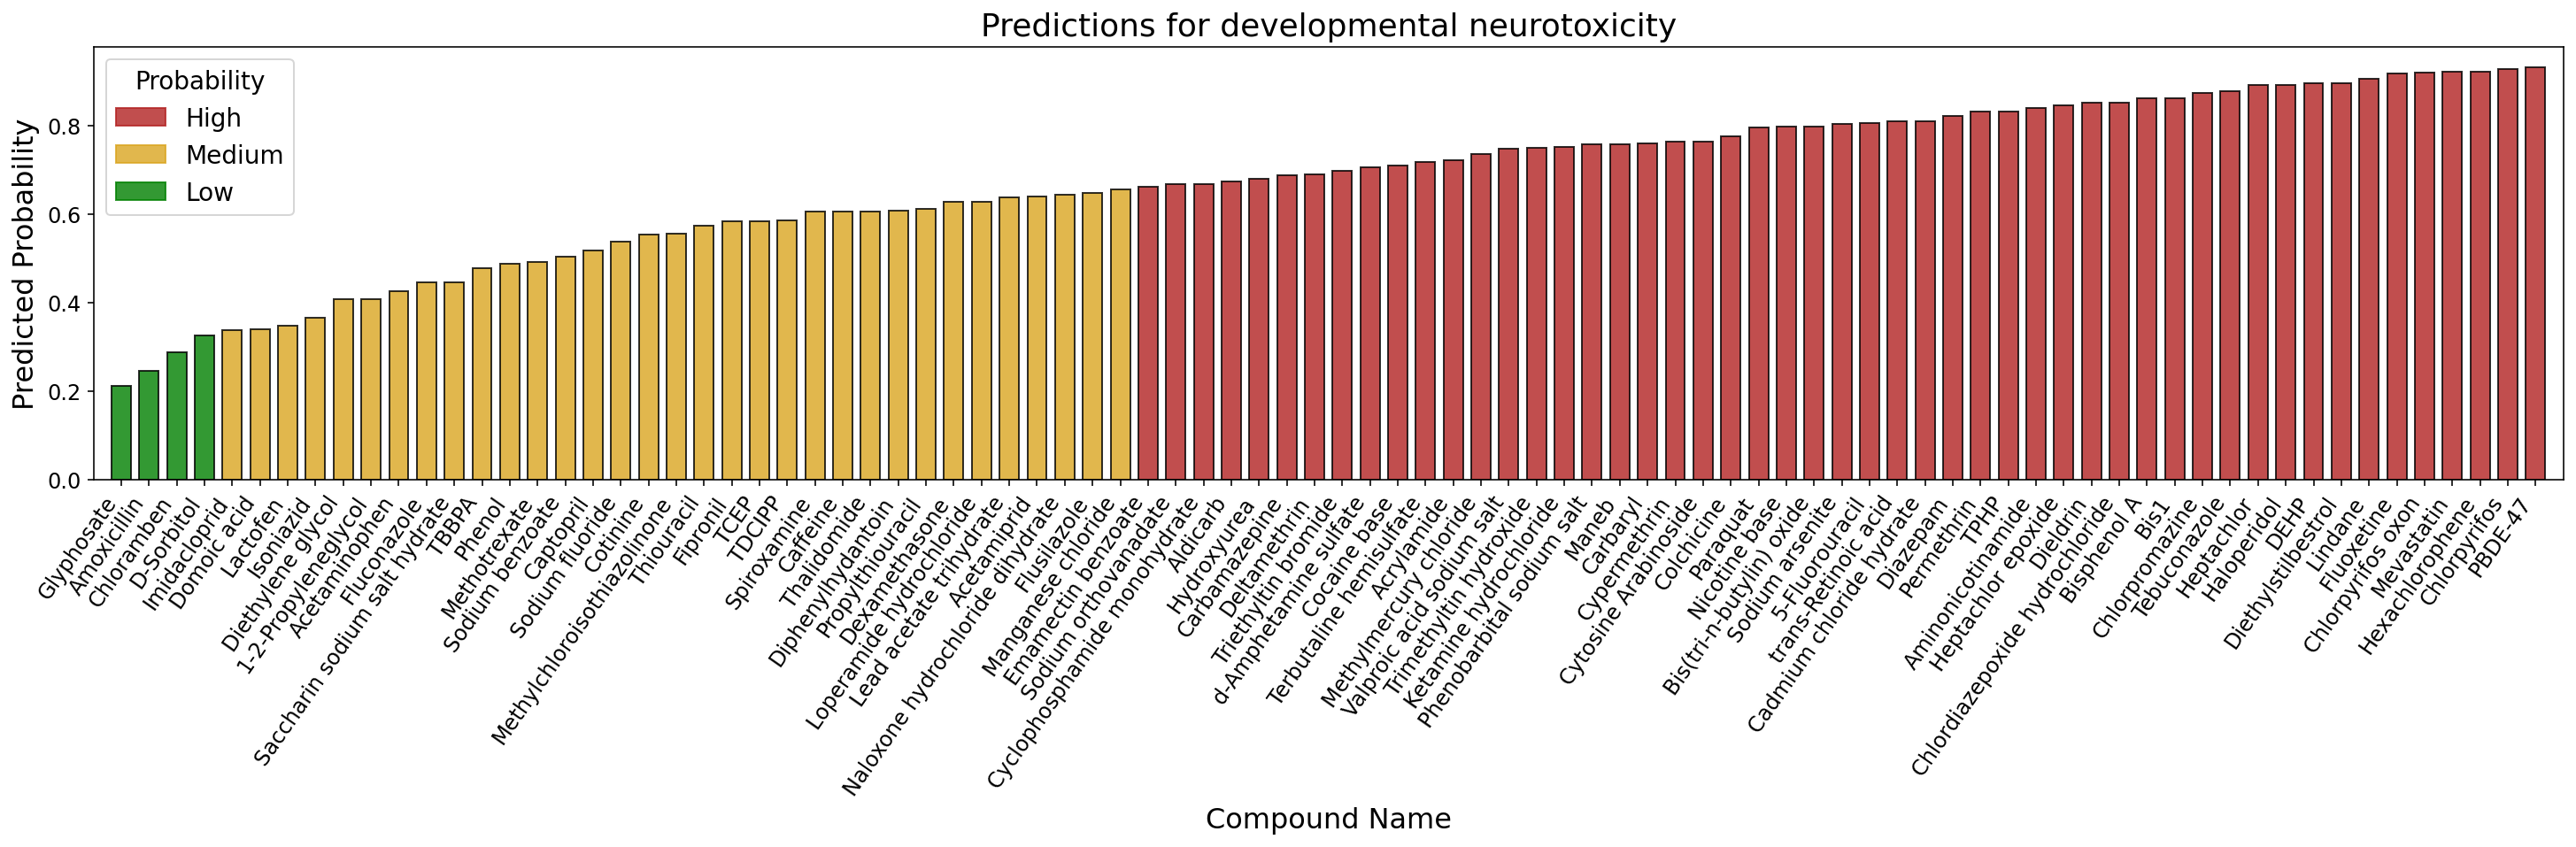

In [63]:
# Colour-coded based on the low, medium and high risk
ylabels= data["Chemical"].astype(str)
obs_dnt = np.squeeze(idata_hierar.posterior_predictive['y_obs_dnt'])
obs_pred = np.reshape(obs_dnt.values, (4000, 88))
avg_obs_pred = obs_pred.mean(axis=0)
order = np.argsort(avg_obs_pred)

new_labeling = np.zeros(avg_obs_pred.shape, dtype=int)
new_labeling[avg_obs_pred < .33] = 0
new_labeling[(avg_obs_pred >= .33) & (avg_obs_pred < .66)] = 1
new_labeling[avg_obs_pred >= .66] = 2

cc = np.asarray(['green', 'goldenrod', 'firebrick'])
class_label = np.squeeze(new_labeling.astype(int))
color_label = cc[class_label]


fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(np.arange(88), avg_obs_pred[order], color=color_label[order], alpha = 0.8, edgecolor='black', width=0.7)

ax.set_xticks(np.arange(88))
ax.set_xticklabels(ylabels[order], fontsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.set_ylabel('Predicted Probability', fontsize=16)
ax.set_xlabel('Compound Name', fontsize=16)
ax.set_title("Predictions for developmental neurotoxicity", 
             fontsize=18)

ax.set_xlim([-1, 88])

green_patch = mpatches.Patch(color='green', label='Low', alpha=0.8)
yellow_patch = mpatches.Patch(color='goldenrod', label='Medium', alpha=0.8)
red_patch = mpatches.Patch(color='firebrick', label='High', alpha=0.8)
plt.legend(handles=[red_patch, yellow_patch, green_patch], title = 'Probability', title_fontsize=14, fontsize=14)

fig.autofmt_xdate(rotation=55);

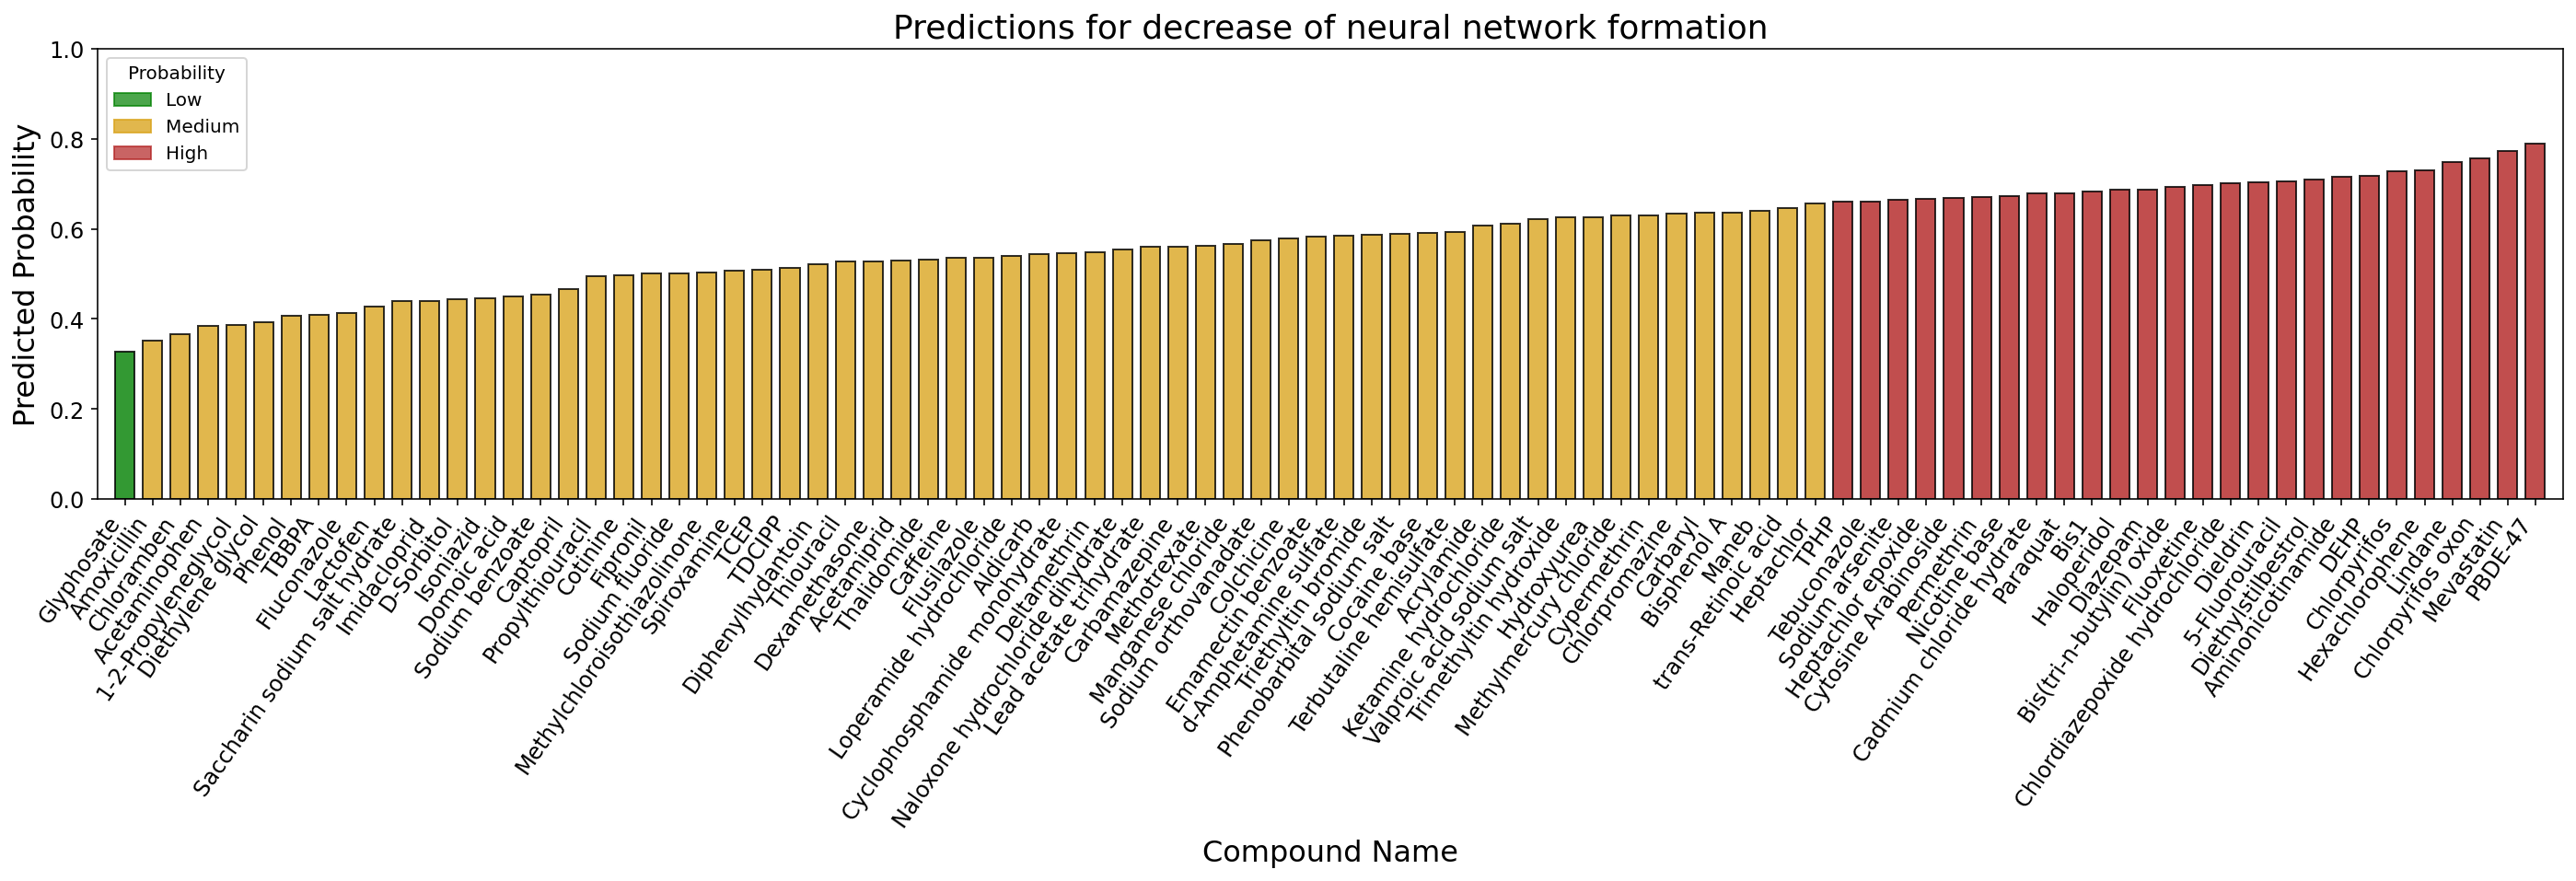

In [64]:
# Colour-coded based on the low, medium and high risk

obs_nnf = np.squeeze(idata_hierar.posterior_predictive['y_obs_nnf'])
obs_pred = np.reshape(obs_nnf.values, (4000, 88))
avg_obs_pred = obs_pred.mean(axis=0)
order = np.argsort(avg_obs_pred)

new_labeling = np.zeros(avg_obs_pred.shape, dtype=int)
new_labeling[avg_obs_pred < .33] = 0
new_labeling[(avg_obs_pred >= .33) & (avg_obs_pred < .66)] = 1
new_labeling[avg_obs_pred >= .66] = 2

cc = np.asarray(['green', 'goldenrod', 'firebrick'])
class_label = np.squeeze(new_labeling.astype(int))
color_label = cc[class_label]


fig, ax = plt.subplots(figsize=(24, 5))
ax.bar(np.arange(88), avg_obs_pred[order], color=color_label[order], alpha = 0.8, edgecolor='black', width=0.7)

ax.set_xticks(np.arange(88))
ax.set_xticklabels(ylabels[order], fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Predicted Probability', fontsize=16)
ax.set_xlabel('Compound Name', fontsize=16)
ax.set_title("Predictions for decrease of neural network formation", fontsize=18)

ax.set_xlim([-1, 88])
ax.set_ylim([0, 1])

green_patch = mpatches.Patch(color='green', label='Low', alpha=0.7)
yellow_patch = mpatches.Patch(color='goldenrod', label='Medium', alpha=0.8)
red_patch = mpatches.Patch(color='firebrick', label='High', alpha=0.7)
plt.legend(handles=[green_patch, yellow_patch, red_patch], title="Probability")

fig.autofmt_xdate(rotation=55);

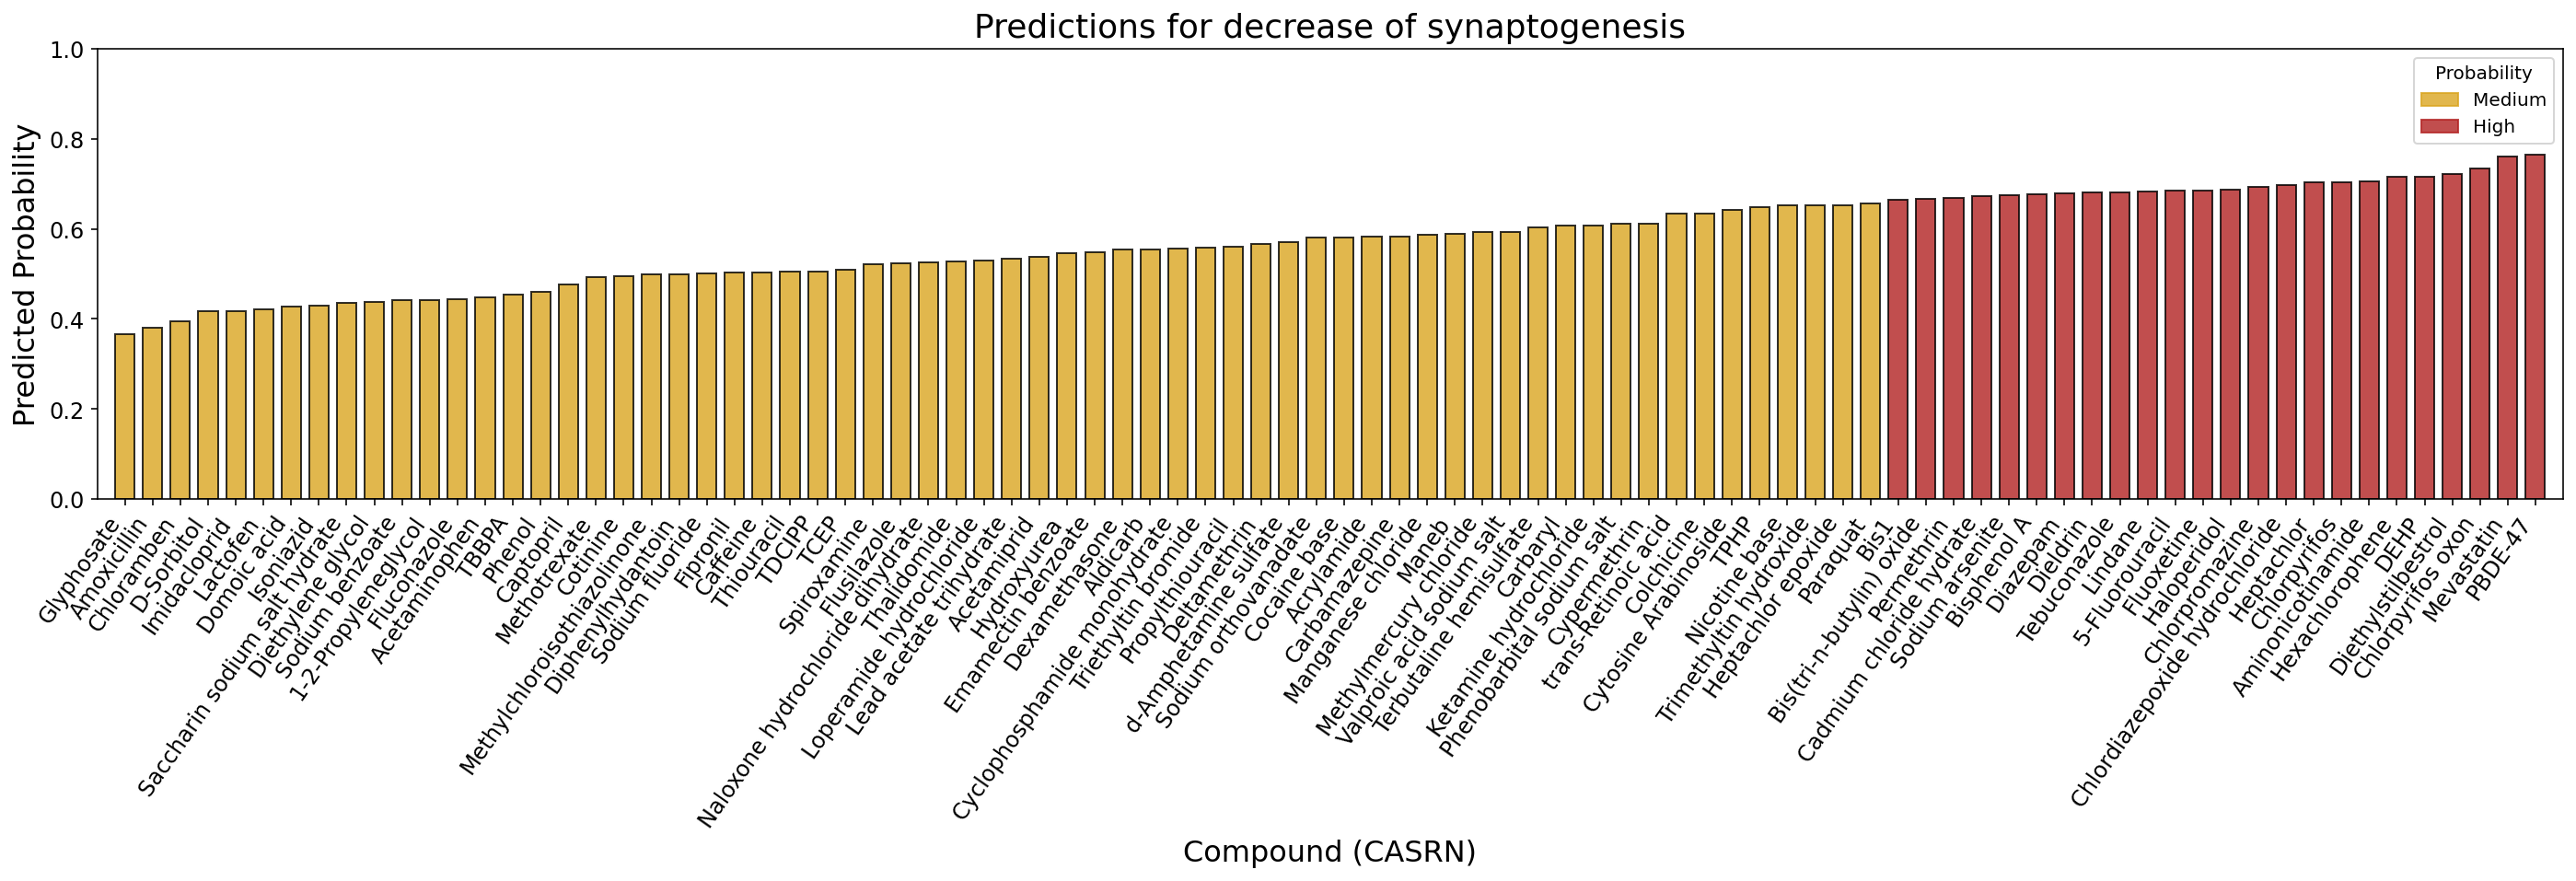

In [65]:
# Colour-coded based on the low, medium and high risk

obs_syn = np.squeeze(idata_hierar.posterior_predictive['y_obs_syn'])
obs_pred = np.reshape(obs_syn.values, (4000, 88))
avg_obs_pred = obs_pred.mean(axis=0)
order = np.argsort(avg_obs_pred)

new_labeling = np.zeros(avg_obs_pred.shape, dtype=int)
new_labeling[avg_obs_pred < .33] = 0
new_labeling[(avg_obs_pred >= .33) & (avg_obs_pred < .66)] = 1
new_labeling[avg_obs_pred >= .66] = 2

cc = np.asarray(['green', 'goldenrod', 'firebrick'])
class_label = np.squeeze(new_labeling.astype(int))
color_label = cc[class_label]


fig, ax = plt.subplots(figsize=(24, 5))
ax.bar(np.arange(88), avg_obs_pred[order], color=color_label[order], alpha = 0.8, edgecolor='black', width=0.7)

ax.set_xticks(np.arange(88))
ax.set_xticklabels(ylabels[order], fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Predicted Probability', fontsize=16)
ax.set_xlabel('Compound (CASRN)', fontsize=16)
ax.set_title("Predictions for decrease of synaptogenesis", fontsize=18)

ax.set_xlim([-1, 88])
ax.set_ylim([0, 1])

#green_patch = mpatches.Patch(color='green', label='Low', alpha=0.7)
yellow_patch = mpatches.Patch(color='goldenrod', label='Medium', alpha=0.8)
red_patch = mpatches.Patch(color='firebrick', label='High', alpha=0.8)
plt.legend(handles=[yellow_patch, red_patch], title="Probability")

fig.autofmt_xdate(rotation=55);

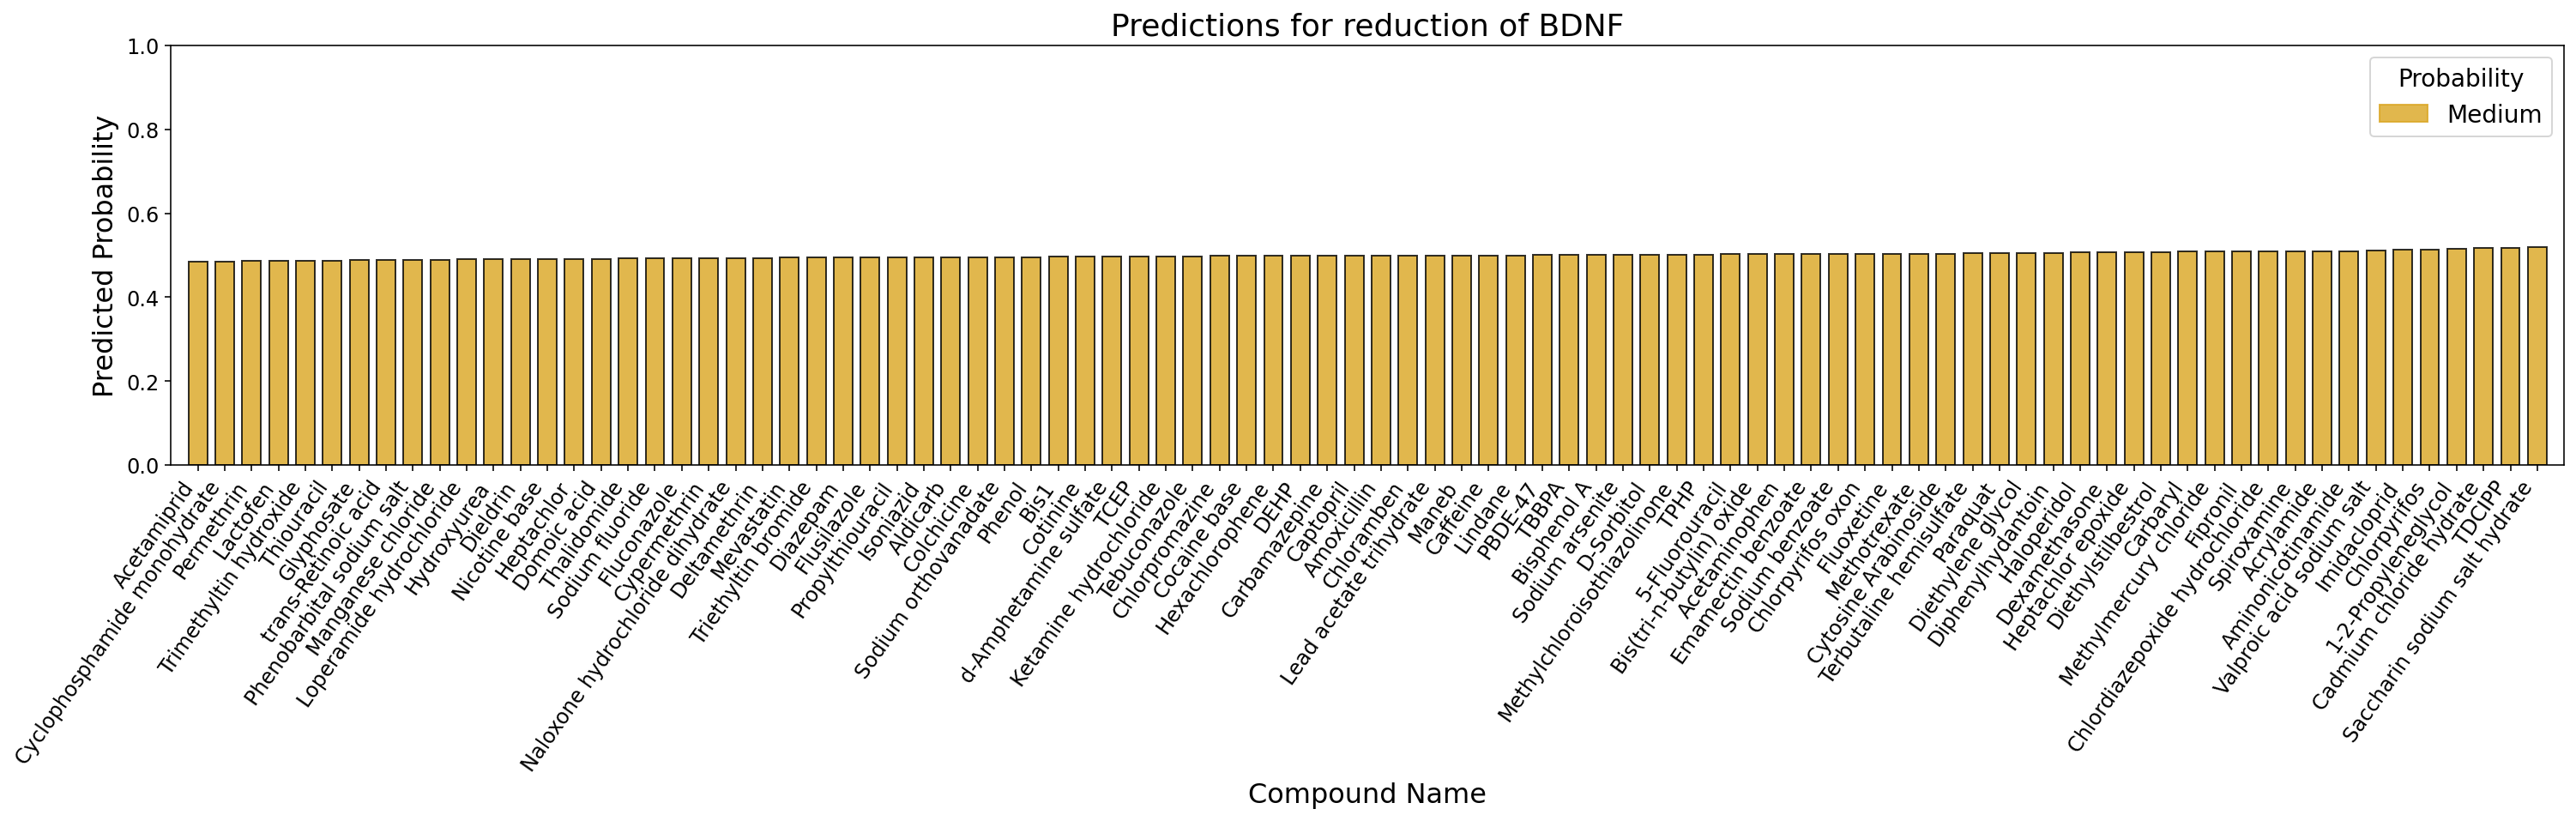

In [67]:
# Colour-coded based on the low, medium and high risk

obs_bdnf = np.squeeze(idata_hierar.posterior_predictive['y_obs_bdnf'])
obs_pred = np.reshape(obs_bdnf.values, (4000, 88))
avg_obs_pred = obs_pred.mean(axis=0)
order = np.argsort(avg_obs_pred)

new_labeling = np.zeros(avg_obs_pred.shape, dtype=int)
new_labeling[avg_obs_pred < .34] = 0
new_labeling[(avg_obs_pred >= .34) & (avg_obs_pred < .67)] = 1
new_labeling[avg_obs_pred >= .67] = 2

cc = np.asarray(['green', 'goldenrod', 'firebrick'])
class_label = np.squeeze(new_labeling.astype(int))
color_label = cc[class_label]


fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(np.arange(88), avg_obs_pred[order], color=color_label[order], alpha = 0.8, edgecolor='black', width=0.7)

ax.set_xticks(np.arange(88))
ax.set_xticklabels(ylabels[order], fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Predicted Probability', fontsize=16)
ax.set_xlabel('Compound Name', fontsize=16)
ax.set_title("Predictions for reduction of BDNF", fontsize=18)

ax.set_xlim([-1, 88])
ax.set_ylim([0, 1])

#green_patch = mpatches.Patch(color='green', label='Low', alpha=0.7)
#yellow_patch = mpatches.Patch(color='goldenrod', label='Medium', alpha=0.7)
# red_patch = mpatches.Patch(color='firebrick', label='High', alpha=0.8)
plt.legend(handles=[yellow_patch], title="Probability", title_fontsize=14, fontsize=14)

fig.autofmt_xdate(rotation=55);